# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
n_episodes=500 #Number of episodes
max_t=500
print_every=100
avg_score = []
scores_deque = deque(maxlen=print_every)
steps = 10
num_update = 10
len_agents = len(str(num_agents))

# initialize the score (for each agent)
scores = np.zeros(num_agents)
# reset the environment    
env_info = env.reset(train_mode=True)[brain_name]
# get the current state (for each agent)    
states = env_info.vector_observations
    
agent_parameters = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
agents = [Agent(**agent_parameters) for _ in range(num_agents)]

assert len(agents) == num_agents
    
for i_episode in range(1, n_episodes+1):
    # get the current state (for each agent)
    states = env_info.vector_observations                  
    for agent in agents:
        agent.reset()
    for t in range(max_t):
        # select actions (for each agent)
        actions = [agent.act(states[idx]) for idx, agent in enumerate(agents)]
        # send all actions to tne environment   
        env_info = env.step(actions)[brain_name]
        # get next state (for each agent)
        next_states = env_info.vector_observations
        # get reward (for each agent)
        rewards = env_info.rewards
        # see if episode finished
        dones = env_info.local_done                        
        #Save experience/reward in replay memory          
        step_tuple = zip(agents, states, actions, rewards, next_states, dones)
            
        for agent, state, action, reward, next_state, done in step_tuple:
            agent.memory.add(state, action, reward, next_state, done)
            if ( t % steps == 0):
                agent.step(num_update)
        # roll over states to next time step
        states  = next_states
        # update the score (for each agent)
        scores += rewards
        # exit loop if episode finished
        if np.any(dones):                                  
            break
    #Total score (averaged over agents) this episode           
    score = np.mean(scores)        
    avg_score.append(score)
    # save most recent score
    scores_deque.append(score)        
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
    
    if i_episode % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        for idx, agent in enumerate(agents):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')        
    if np.mean(scores_deque)>30.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-print_every, np.mean(scores_deque)))
        break   
scores = avg_score


Episode 100	Average Score: 11.20
Episode 180	Average Score: 30.11
Environment solved in 80 episodes!	Average Score: 30.11


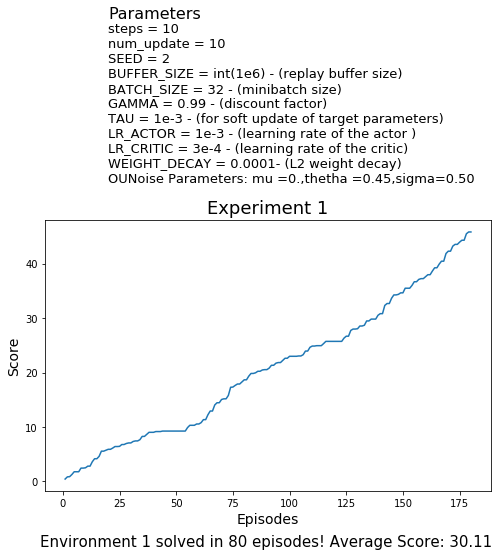

In [8]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

#Parameters
plt.text(20, 85, "Parameters", fontsize=16)
plt.text(20, 55,
"\nsteps = 10"
"\nnum_update = 10"
"\nSEED = 2"
"\nBUFFER_SIZE = int(1e6) - (replay buffer size)"
"\nBATCH_SIZE = 32 - (minibatch size)"
"\nGAMMA = 0.99 - (discount factor)"
"\nTAU = 1e-3 - (for soft update of target parameters)" 
"\nLR_ACTOR = 1e-3 - (learning rate of the actor )"
"\nLR_CRITIC = 3e-4 - (learning rate of the critic)"
"\nWEIGHT_DECAY = 0.0001- (L2 weight decay)"
"\nOUNoise Parameters: mu =0.,thetha =0.45,sigma=0.50", fontsize=13)  

# Plot
plt.plot(np.arange(1, len(scores)+1), scores)
plt.yticks(fontsize=10)    
plt.xticks(fontsize=10) 
plt.ylabel('Score',fontsize=14)
plt.xlabel('Episodes',fontsize=14)
plt.text(-10, -12, "Environment 1 solved in 80 episodes! Average Score: 30.11", fontsize=15)
plt.title("Experiment 1",fontsize=18, ha='center')
fig.savefig('plot_1.png', bbox_inches="tight")
plt.show()

When finished, you can close the environment.

In [7]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 